# COVID19 Global Timeseries data
Source: [JHU CSSE](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series), [Gapminder Dataset](https://www.gapminder.org/downloads/)

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('ggplot')
#plt.rcParams
%matplotlib inline

#### Read CSV files 
Few countries have missing Alpha-3 ISO codes. We have tried to populate them from two different datasources.

In [321]:
confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
covid_confirmed = pd.read_csv(confirmed_cases_url)

recovered_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
covid_recovered = pd.read_csv(recovered_cases_url)

deceased_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
covid_deceased = pd.read_csv(deceased_cases_url)

countries_url1 = 'https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv'
countries1 = pd.read_csv(countries_url1)

countries_url2 = 'https://gist.githubusercontent.com/tadast/8827699/raw/7255fdfbf292c592b75cf5f7a19c16ea59735f74/countries_codes_and_coordinates.csv'
countries2 = pd.read_csv(countries_url2)

In [322]:
def modify_df(_df):
    # Drop Latitude and Longitude
    _df.drop(['Lat', 'Long'], axis=1, inplace=True)
    
    # Create multiindex
    country_df = _df.filter(['Country/Region', 'Province/State'], axis=1)
    
    # Change the index
    _df.index = pd.MultiIndex.from_frame(country_df)
    del country_df
    
    # Groupby country and sum up the cases
    _df = _df.groupby(level="Country/Region").sum()
    
    # Some countries do not have the name in correct format
    _df.rename(index={'US': 'United States', 'Iran':'Iran, Islamic Republic of', 'Korea, South':'South Korea', 'Laos':"Lao People's Democratic Republic", 'Syria':'Syrian Arab Republic', 'Taiwan*':'Taiwan', "Congo (Kinshasa)":'Congo, the Democratic Republic of the',"Congo (Brazzaville)":'Congo', "Cote d'Ivoire":'Ivory Coast', 'Moldova':'Moldova, Republic of', 'Tanzania':'Tanzania, United Republic of'}, inplace=True)
            
    
    # Return a Transposed df which is in a more readable format
    return _df.transpose()   

In [323]:
def status_by_country(_country):
    
    plt.figure(figsize=(20,10))
    plt.plot(covid_confirmed[_country], 'b*-', label='Confirmed')
    plt.plot(covid_recovered[_country], 'g+-', label='Recovered')
    plt.plot(covid_deceased[_country], 'ro-', label='Deceased')
    plt.legend(loc='best')
    plt.xticks(rotation=45);
    plt.grid(alpha=0.75)
    plt.title(_country +' - COVID19 cases till date');

In [324]:
def daily_cases_by_country(_country):
    
    _df = covid_confirmed[_country]
    _df = _df.diff()
    _df.plot(kind='bar', figsize=(20,10), title=_country+' - COVID19 cases by day')
    plt.xticks(rotation=45);

In [325]:
covid_confirmed = modify_df(covid_confirmed)
covid_recovered = modify_df(covid_recovered)
covid_deceased = modify_df(covid_deceased)

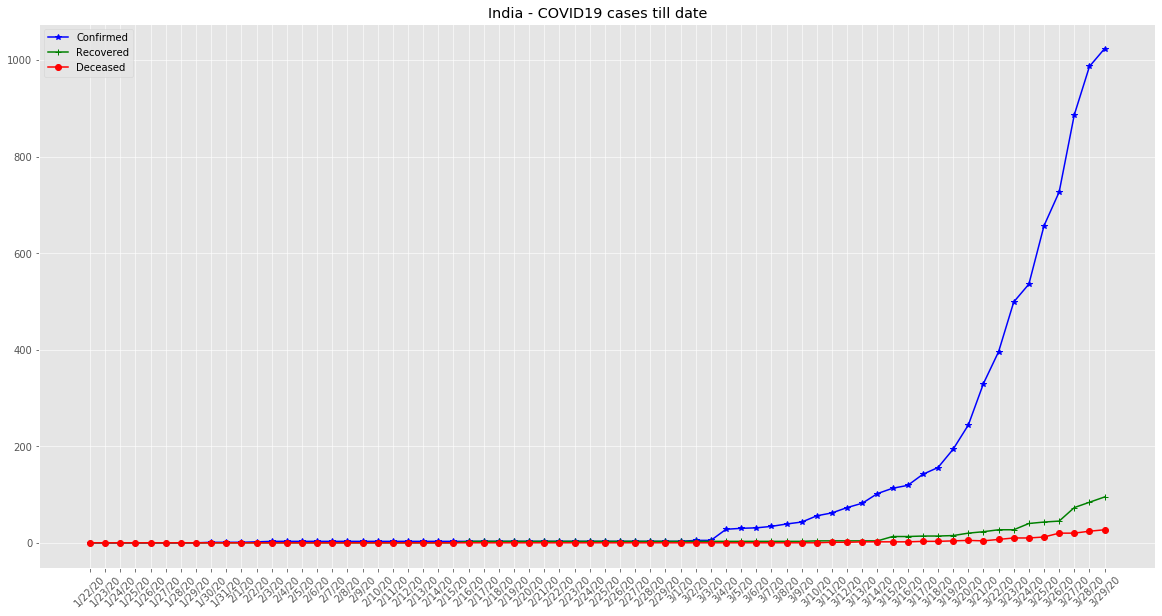

In [326]:
status_by_country('India')

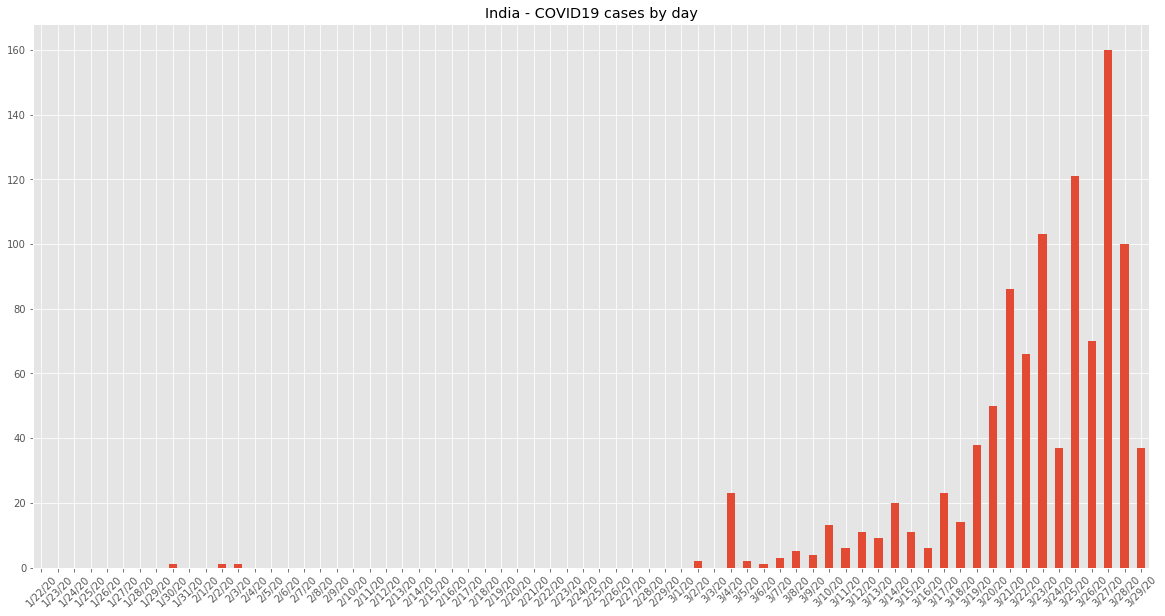

In [327]:
daily_cases_by_country('India')

In [328]:
countries1.columns = ['Country', 'alpha-2', 'alpha-3', 'country-code', 'iso_3166-2', 'region',
       'sub-region', 'intermediate-region', 'region-code', 'sub-region-code',
       'intermediate-region-code']

In [329]:
countries2['Alpha-3 code'] = countries2['Alpha-3 code'].apply(lambda x: x.replace('"','').strip(" "))

In [330]:
countries1_dict = pd.Series(countries1['alpha-3'].values,index=countries1['Country']).to_dict()
countries2_dict = pd.Series(countries2['Alpha-3 code'].values,index=countries2['Country']).to_dict()

In [333]:
# Chloropleth map 

# Need to look at the last row
# and transpose back to a format
# that is easily readable by plotly

_df = covid_confirmed.iloc[-1]
_df = _df.transpose()
_df = _df.to_frame()
_df.reset_index(inplace=True)
_df.columns = ['Country','Current_cases']
_df = pd.merge(_df, countries1, on='Country', how='left')
_df = pd.merge(_df, countries2, on='Country', how='left')
_df['alpha-3'] = _df['alpha-3'].fillna(_df['Country'].map(countries1_dict))
_df['alpha-3'] = _df['alpha-3'].fillna(_df['Country'].map(countries2_dict))

In [334]:
fig = px.choropleth(_df, locations='Alpha-3 code',
                    color="Current_cases", 
                    hover_name="Country", 
                    color_continuous_scale=px.colors.sequential.Burg)
fig.show()